# Initial Work on Vision for Map Construction

In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Vision Setup/Calibration

### Load Image

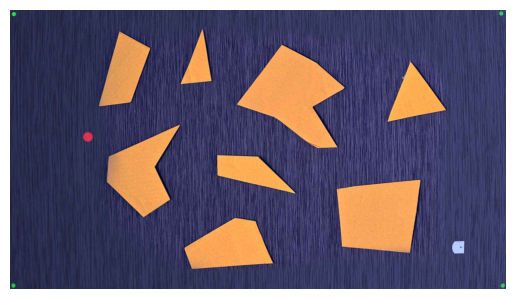

In [19]:
# Load dummy image from images/
img = cv2.imread('../images/robot_nav_map_distorted.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

In [15]:
# Confirm that the image is indeed 1920x1080 RGB
img.shape

(1080, 1920, 3)

### Perspective Transformation Matrix

Calibrate the camera using the 4 green markers in the corners of the map. Map's real-world dimensions are 445cm x 250cm.

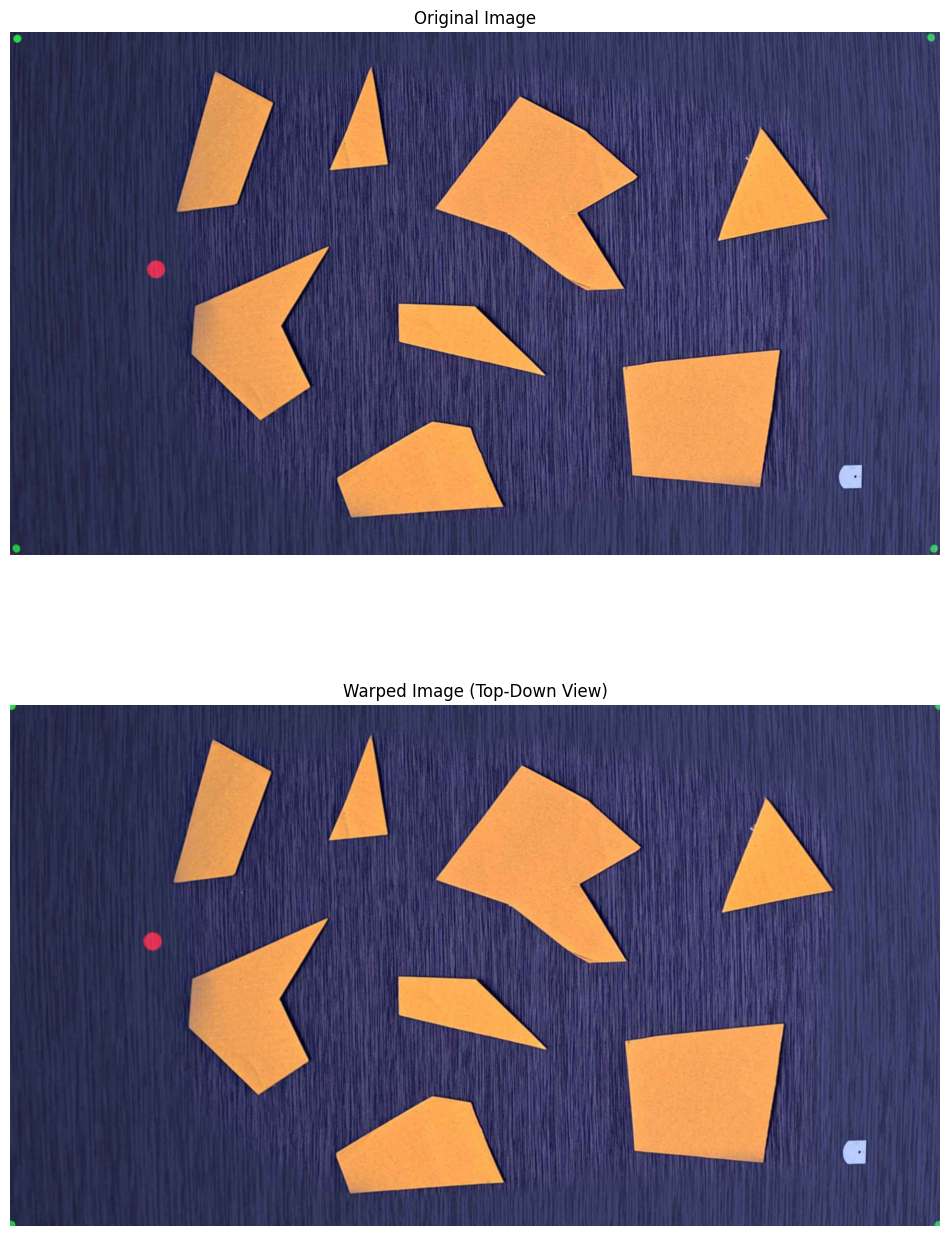

Perspective Transformation Matrix:


array([[ 1.00196029e+00,  1.89585674e-03, -1.20462737e+01],
       [ 1.06519036e-03,  1.00767008e+00, -1.21048232e+01],
       [ 1.00489657e-06,  4.49590714e-06,  1.00000000e+00]])

In [ ]:
# Define the pixel coordinates of the 4 green markers (corners of the map)
# Let's assume they are almost exactly at the corners of the image for this example
src_points = np.array([[12, 12], [1904, 10], [10, 1069], [1911, 1069]], dtype=np.float32)

pxl_width = 1904 - 12  # width in pixels
pxl_height = 1069 - 12  # height in pixels
pxl_per_cm_x = pxl_width / 445.0  # pixels per cm in x direction
pxl_per_cm_y = pxl_height / 250.0  # pixels per cm in y direction

# Define the real-world map dimensions in cm (445cm x 250cm)
dst_points = np.array([[0, 0], [pxl_width, 0], [0, pxl_height], [pxl_width, pxl_height]], dtype=np.float32)


perspective_matrix = cv2.getPerspectiveTransform(src_points, dst_points)

# Perform the perspective transformation, and plot the two images side by side (v-stacked)
warped_img = cv2.warpPerspective(img, perspective_matrix, (pxl_width, pxl_height))
plt.figure(figsize=(12, 16))
plt.subplot(2, 1, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.subplot(2, 1, 2)
plt.imshow(warped_img)
plt.title("Warped Image (Top-Down View)")
plt.axis("off")
plt.show()

print("Perspective Transformation Matrix:")
perspective_matrix

## Map Construction

### 1. Image Segmentation

Now we separate the image into three binary masks: Obstacles, Target, Robot.

<ins style="color: salmon">**TODO: Would be better to detect robot using ArUco markers for more robust detection (also more useful for pose estimation).**</ins>

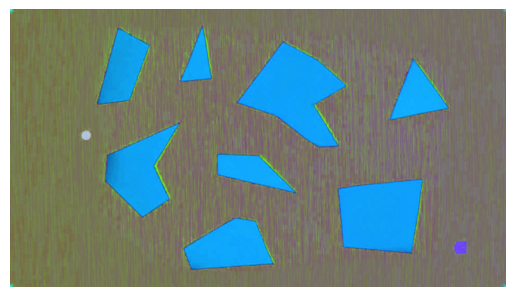

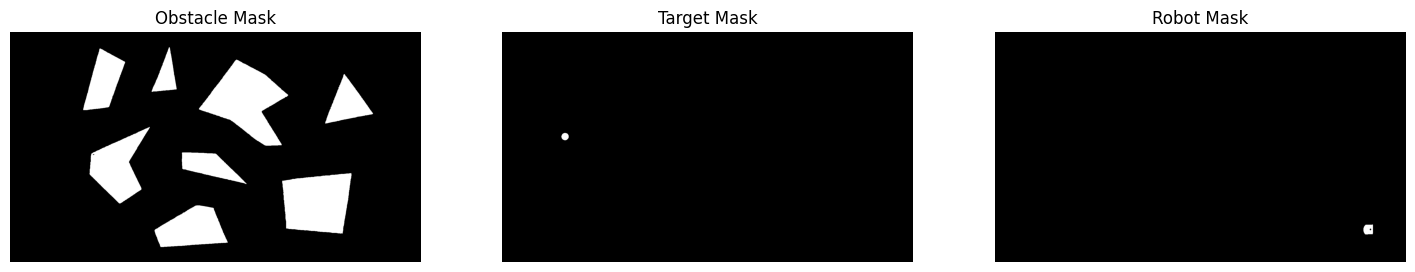

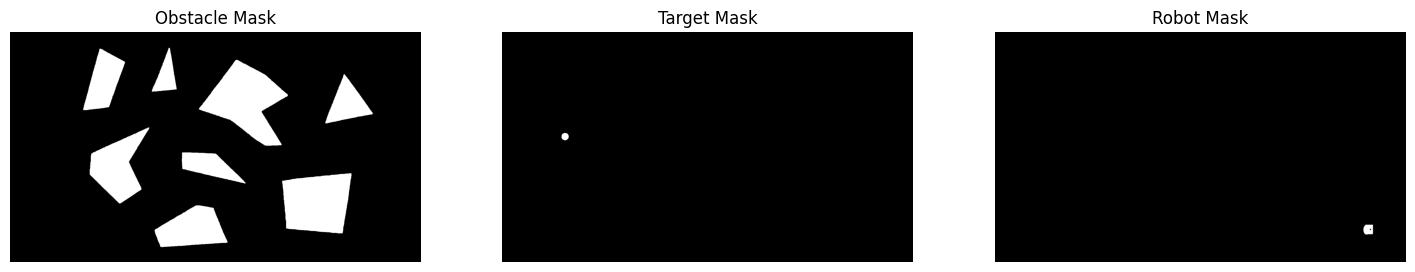

In [ ]:
# Convert the image to HSV color space for better color segmentation
hsv_img = cv2.cvtColor(warped_img, cv2.COLOR_RGB2HSV)
# Small blur to reduce noise
hsv_img = cv2.GaussianBlur(hsv_img, (7, 7), 0)
plt.imshow(hsv_img)
plt.axis("off")

# Define hsv color ranges for obstacles (light, low-saturation orange), target (red-magenta), and robot (white)
# HSV ranges in OpenCV: H=0-179, S=0-255, V=0-255
obstacle_lower = np.array([10, 70, 180])
obstacle_upper = np.array([25, 255, 255])
target_lower = np.array([150, 125, 175])
target_upper = np.array([179, 255, 255])
robot_lower = np.array([0, 0, 220])
robot_upper = np.array([179, 80, 255])

# Create binary masks for each category
obstacle_mask = cv2.inRange(hsv_img, obstacle_lower, obstacle_upper)
target_mask = cv2.inRange(hsv_img, target_lower, target_upper)
robot_mask = cv2.inRange(hsv_img, robot_lower, robot_upper)

# Display the masks
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Obstacle Mask")
plt.imshow(obstacle_mask, cmap="gray")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.title("Target Mask")
plt.imshow(target_mask, cmap="gray")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.title("Robot Mask")
plt.imshow(robot_mask, cmap="gray")
plt.axis("off")
plt.show()

# Further cleanup using morphological operations
kernel = np.ones((5, 5), np.uint8)
# 1. Morphological opening (erode > dilate) to remove small salt&pepper noise
obstacle_mask = cv2.morphologyEx(obstacle_mask, cv2.MORPH_OPEN, kernel)
target_mask = cv2.morphologyEx(target_mask, cv2.MORPH_OPEN, kernel)
robot_mask = cv2.morphologyEx(robot_mask, cv2.MORPH_OPEN, kernel)
# 2. Morphological closing (dilate > erode) to fill small holes
obstacle_mask = cv2.morphologyEx(obstacle_mask, cv2.MORPH_CLOSE, kernel)
target_mask = cv2.morphologyEx(target_mask, cv2.MORPH_CLOSE, kernel)
robot_mask = cv2.morphologyEx(robot_mask, cv2.MORPH_CLOSE, kernel)


# Display the masks
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Obstacle Mask")
plt.imshow(obstacle_mask, cmap="gray")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.title("Target Mask")
plt.imshow(target_mask, cmap="gray")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.title("Robot Mask")
plt.imshow(robot_mask, cmap="gray")
plt.axis("off")
plt.show()

### 2. Configuration Space Construction

The Thymio II is 11cm x 11cm, so we will dilate obstacles by a little over 11cm to create the initial configuration space. Then, we approximate the obstacles as polygons for a nicer visibility graph.

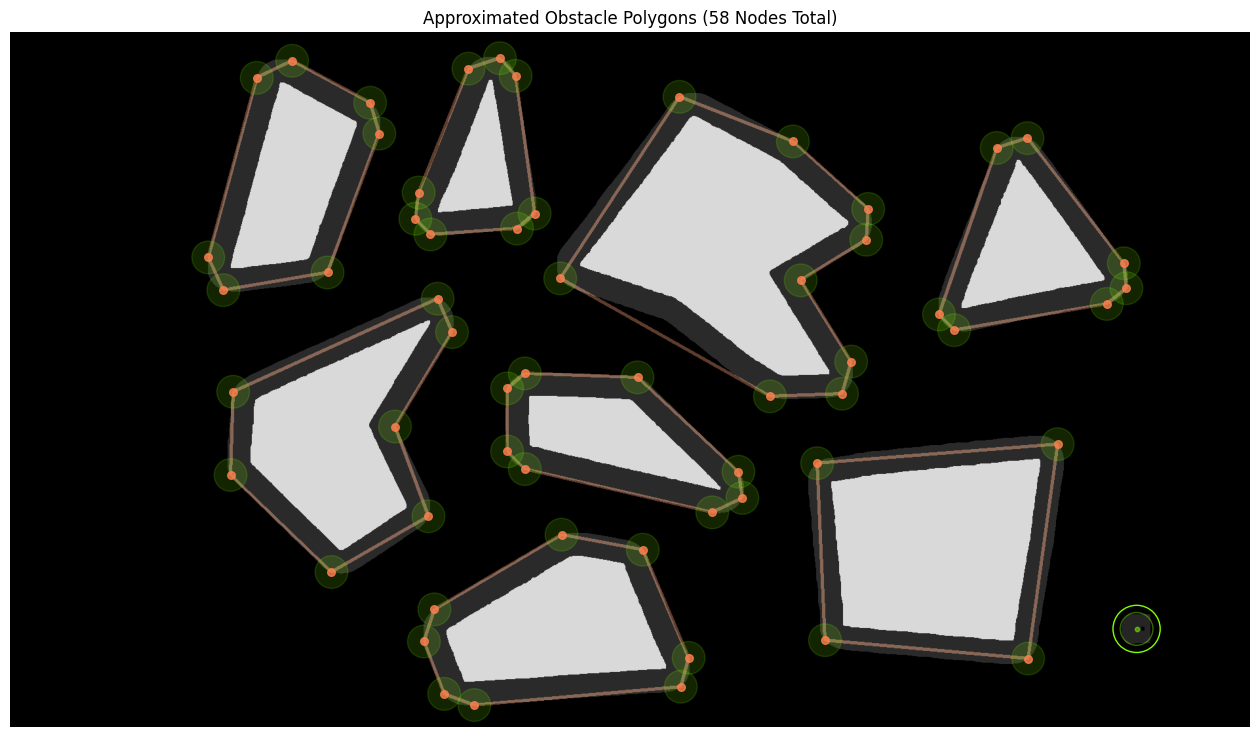

In [ ]:
robot_radius = 6.0
robot_buffer = robot_radius + 2.5
robot_radius_px = int(robot_radius * pxl_per_cm_x)
padding_px = int(robot_buffer * pxl_per_cm_x)

# Dilate obstacle mask to create configuration space
dilation_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (padding_px * 2, padding_px * 2))
dilated_obstacle_mask = cv2.dilate(obstacle_mask, dilation_kernel, iterations=1)

# Find contours of the dilated obstacles
contours, _ = cv2.findContours(dilated_obstacle_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Approximate contours as polygons
approx_polygons = []
for contour in contours:
    epsilon = 0.015 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    approx_polygons.append(approx)

# Display the approximated polygons on the dilated obstacle mask
polygon_img = cv2.cvtColor(obstacle_mask, cv2.COLOR_GRAY2RGB)
for poly in approx_polygons:
    cv2.polylines(polygon_img, [poly], isClosed=True, color=(140, 90, 65), thickness=3)

plt.figure(figsize=(16, 10))
plt.imshow(polygon_img, alpha=1)
plt.imshow(dilated_obstacle_mask, cmap="gray", alpha=0.2)

# polygon_nodes_pxs = [poly * pxl_per_cm_x for poly in approx_polygons]
for polygon in approx_polygons:
    for pt in polygon:
        robot_circle = plt.Circle(pt[0], robot_radius_px, color="chartreuse", alpha=0.15, fill=True, linewidth=1)
        plt.gca().add_patch(robot_circle)
        plt.scatter(*pt[0], color="coral", s=30, alpha=0.8, marker="o")

# Also plot the robot mask and the buffer we chose to dilate by
plt.imshow(robot_mask, cmap="gray", alpha=0.15)
# Add a circle of diameter equal to the dilation at the robot's centroid
robot_pos_px = np.mean(np.argwhere(robot_mask > 0), axis=0)[::-1]  # (x, y) format
plt.scatter(*robot_pos_px, color="chartreuse", alpha=0.5, s=10, marker="o")
robot_circle = plt.Circle(robot_pos_px, robot_radius_px, color="chartreuse", alpha=0.4, fill=False, linewidth=1)
circle_outer = plt.Circle(robot_pos_px, padding_px, color="chartreuse", fill=False, linewidth=1)
plt.gca().add_patch(robot_circle)
plt.gca().add_patch(circle_outer)

plt.title(f"Approximated Obstacle Polygons ({sum(len(poly) for poly in approx_polygons)} Nodes Total)")
plt.axis("off")
plt.show()

Works okay, but how about instead of dilating with an ellipsoidal kernel and approximating polygons using Douglas-Peucker, we instead approximate the polygons first and thencompute a sharper, "mitre-jointed" buffer that preserves the polygon shape better? The `shapely` library has good support for this.

In [ ]:
# Helper for merging close vertices below (polygon simplification)
def merge_close_vertices(pts, min_dist=5.0):
    """
    pts: Numpy array of shape (N, 2)
    min_dist: Minimum distance (in cm) allowed between vertices
    """
    if len(pts) < 3:
        return pts

    new_pts = [pts[0]]
    for i in range(1, len(pts)):
        dist = np.linalg.norm(pts[i] - new_pts[-1])
        if dist > min_dist:
            new_pts.append(pts[i])
        else:
            # Merge points by averaging
            new_pts[-1] = (new_pts[-1] + pts[i]) / 2.0

    # Check closure (distance between last and first)
    if np.linalg.norm(np.array(new_pts[-1]) - np.array(new_pts[0])) < min_dist:
        new_pts.pop()

    return np.array(new_pts).reshape(-1, 2)

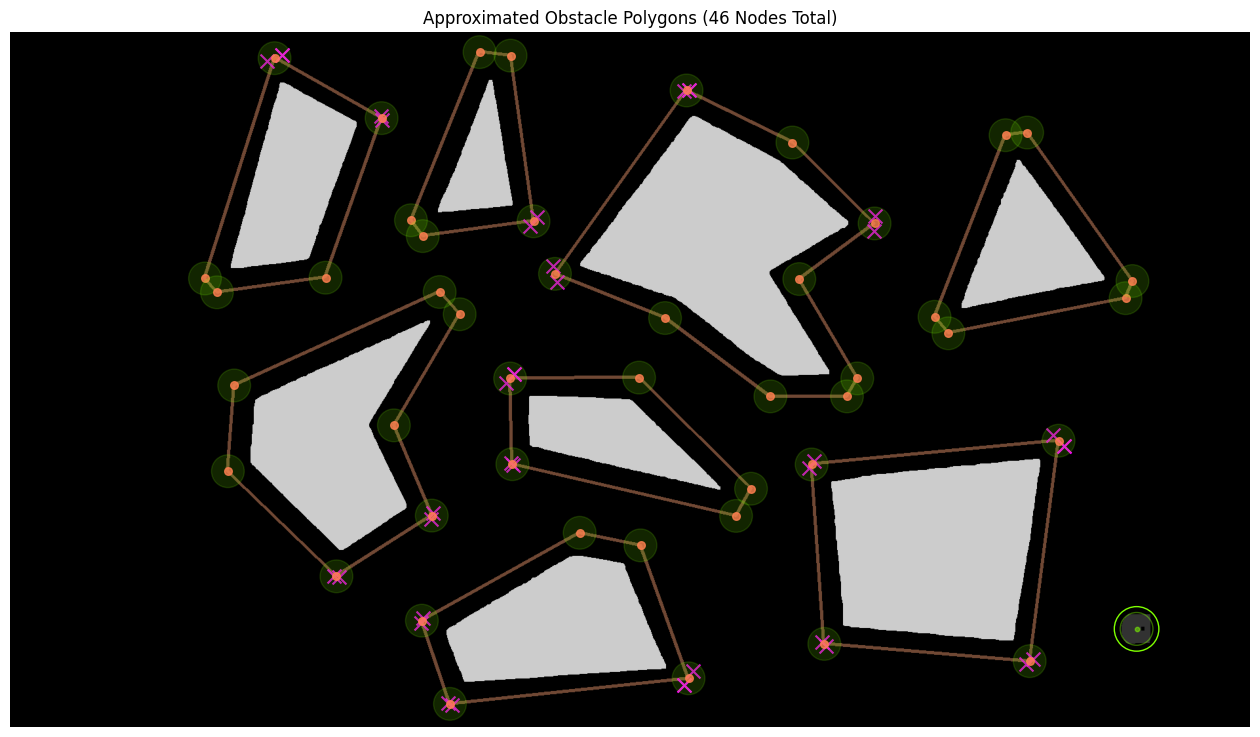

In [ ]:
from shapely.geometry import Polygon

robot_radius = 6.0
robot_buffer = robot_radius + 2
robot_radius_px = int(robot_radius * pxl_per_cm_x)
padding_px = int(robot_buffer * pxl_per_cm_x)

# Get contours like before, but on the original obstacle mask
contours, _ = cv2.findContours(obstacle_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Now, approximate contours as polygons right-away, and then buffer using shapely
final_polygons = []
eliminated_nodes = []
for cnt in contours:
    epsilon = 0.01 * cv2.arcLength(cnt, True)
    pts = cv2.approxPolyDP(cnt, epsilon, True).reshape(-1, 2) / pxl_per_cm_x
    polygon = Polygon(pts)

    # Buffer (Dilate) with 'mitre' join_style for sharp corners - mitre_limit helps cut-off excessive spikes
    buffered_poly = polygon.buffer(robot_buffer, join_style="mitre", mitre_limit=1.2, resolution=1)
    buffered_poly_pts = np.array(buffered_poly.exterior.coords).reshape(-1, 2)
    # Chopped spikes may have left close vertices, so merge them using our helper
    final_poly_pts = merge_close_vertices(buffered_poly_pts, min_dist=6)
    final_polygons.append(final_poly_pts)

    # Tracking eliminated nodes for visualization
    eliminated_nodes += [pt for pt in buffered_poly_pts if pt not in final_poly_pts]

# Plot the approximated polygons
polygon_img = cv2.cvtColor(obstacle_mask, cv2.COLOR_GRAY2RGB)
for poly in final_polygons:
    cv2.polylines(
        polygon_img, [(poly * pxl_per_cm_x).astype(np.int32)], isClosed=True, color=(140, 90, 65), thickness=3
    )

plt.figure(figsize=(16, 10))
plt.imshow(polygon_img, alpha=1)

# Plot eliminated nodes
eliminated_nodes_pxs = np.array(eliminated_nodes) * pxl_per_cm_x
for pt in eliminated_nodes_pxs:
    plt.scatter(*pt, color="magenta", s=100, alpha=0.8, marker="x")

# Plot final polygon nodes, with feint robot circles to visualize clearance
polygon_nodes_pxs = [poly * pxl_per_cm_x for poly in final_polygons]
for polygon in polygon_nodes_pxs:
    for pt in polygon:
        # Robot clearance circle first
        robot_circle = plt.Circle(pt, robot_radius_px, color="chartreuse", alpha=0.15, fill=True, linewidth=1)
        plt.gca().add_patch(robot_circle)
        # Then the node itself on top
        plt.scatter(*pt, color="coral", s=30, alpha=0.8, marker="o")

# Also plot the robot mask, and its circle + padded-circle approximations
plt.imshow(robot_mask, cmap="gray", alpha=0.2)
# Plot centroid as dot
robot_pos_px = np.mean(np.argwhere(robot_mask > 0), axis=0)[::-1]  # (x, y) format
plt.scatter(*robot_pos_px, color="chartreuse", alpha=0.5, s=10, marker="o")
# Plot robot and padded-robot circles on top of the robot too
robot_circle = plt.Circle(robot_pos_px, robot_radius_px, color="chartreuse", alpha=0.4, fill=False, linewidth=1)
circle_outer = plt.Circle(robot_pos_px, padding_px, color="chartreuse", fill=False, linewidth=1)
plt.gca().add_patch(robot_circle)
plt.gca().add_patch(circle_outer)

plt.title(f"Approximated Obstacle Polygons ({sum(len(poly) for poly in final_polygons)} Nodes Total)")
plt.axis("off")
plt.show()

Nice! We end up with a little less nodes and better preservation of obstacle shapes - a good setup for visibility graph construction.

### 3. Goal & Robot Localization

The robot is kind of already done - but again later we should use ArUco markers for better localization. Let's just get the goal position from the target mask for now.

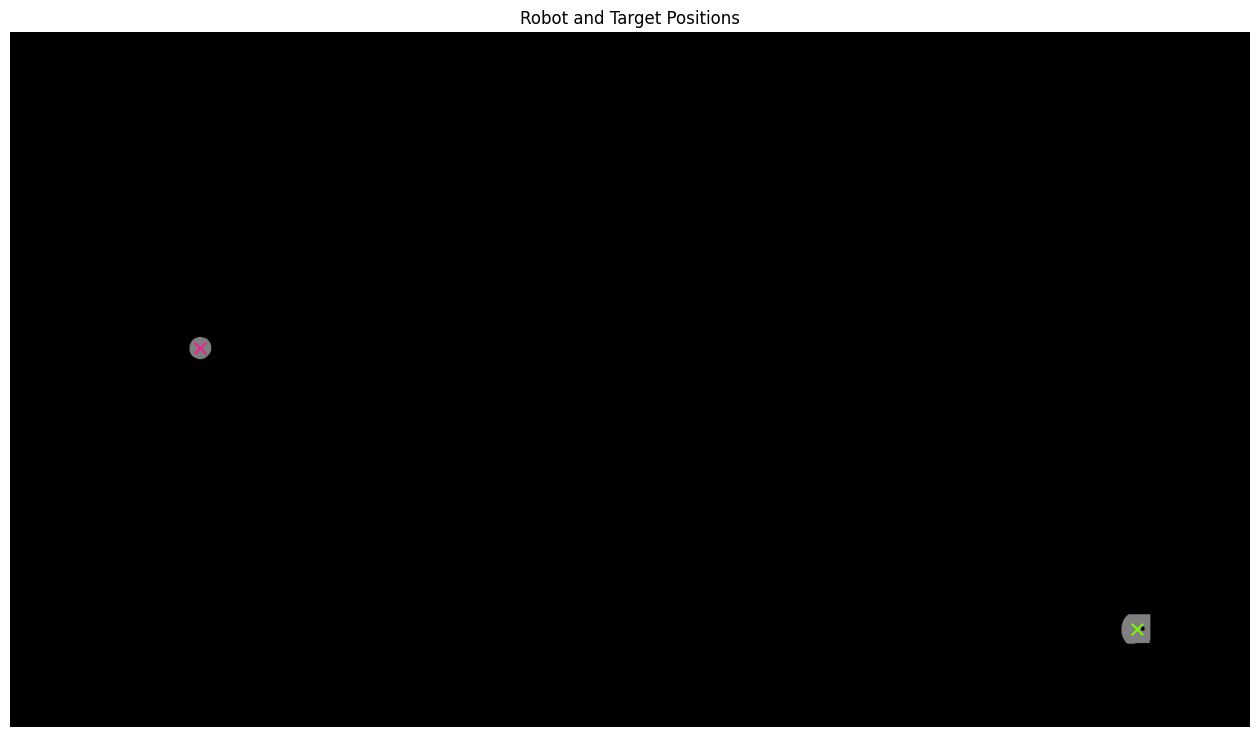

In [781]:
# Robot (repeated)
plt.figure(figsize=(16, 10))
plt.imshow(robot_mask, cmap="gray", alpha=1)
robot_pos_px = np.mean(np.argwhere(robot_mask > 0), axis=0)[::-1]  # (x, y) format
plt.scatter(*robot_pos_px, color="chartreuse", alpha=0.9, s=70, marker="x")

# Target
plt.imshow(target_mask, cmap="gray", alpha=0.5)
target_pos_px = np.mean(np.argwhere(target_mask > 0), axis=0)[::-1]  # (x, y) format
plt.scatter(*target_pos_px, color="deeppink", alpha=0.9, s=70, marker="x")

plt.title("Robot and Target Positions")
plt.axis("off")
plt.show()

### 4. Visibility Graph Construction

In [786]:
import networkx as nx
from shapely.geometry import LineString, Point
import itertools
import numpy as np


def construct_visibility_graph(nodes, obstacles, start_pos, goal_pos):
    """
    nodes: List of (x,y) tuples (all polygon vertices)
    obstacles: List of Shapely Polygon objects
    start_pos: (x,y)
    goal_pos: (x,y)
    """

    # 1. Prepare the graph & points
    G = nx.Graph()
    all_pts = nodes + [start_pos, goal_pos]

    # Map points to indices for easier graph handling ==> points_dict = {index: (x,y)}
    for i, pt in enumerate(all_pts):
        G.add_node(i, pos=pt)

    # Let's add the obstacle "wall" edges first
    for poly in obstacles:
        poly_pts = list(poly.exterior.coords)
        num_pts = len(poly_pts)
        for i in range(num_pts):
            p1 = poly_pts[i]
            p2 = poly_pts[(i + 1) % num_pts]  # Wrap around to first point
            j = all_pts.index(p1)
            k = all_pts.index(p2)
            G.add_edge(j, k, weight=LineString([p1, p2]).length)

    # 2. Iterate all possible pairs of nodes for line-of-sight checks
    for (i, p1), (j, p2) in itertools.combinations(enumerate(all_pts), 2):
        if p1 == p2:
            continue

        line = LineString([p1, p2])
        dist = line.length

        # --- THE INTERSECTION TEST ---
        is_visible = True

        # We shrink the line slightly to avoid "touching" errors at vertices.
        # Done by interpolating 0.01% from start and 99.99% from start (=0.01% from end).
        interp_epsilon = 0.01
        test_line = LineString([line.interpolate(interp_epsilon), line.interpolate(dist - interp_epsilon)])

        for poly in obstacles:
            # Check 1: Does the shrunk line hit an obstacle?
            if test_line.intersects(poly):
                is_visible = False
                break

            # Check 2 (Crucial for Concave shapes):
            # If the line is completely WITHIN a single polygon (e.g. connecting tips of a 'U' shape),
            # intersects might be False, but the path is invalid.
            if test_line.within(poly):
                is_visible = False
                break

        # 3. Add Edge if visible
        if is_visible:
            G.add_edge(i, j, weight=dist)

    return G, all_pts

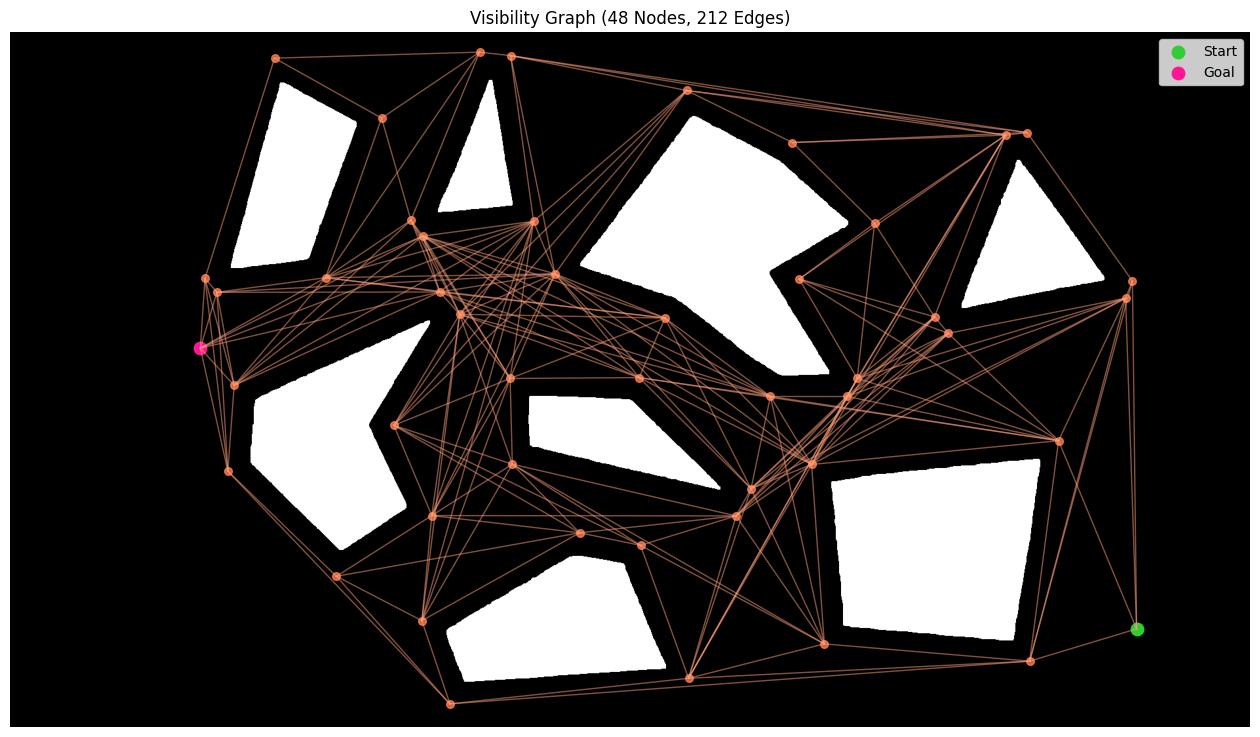

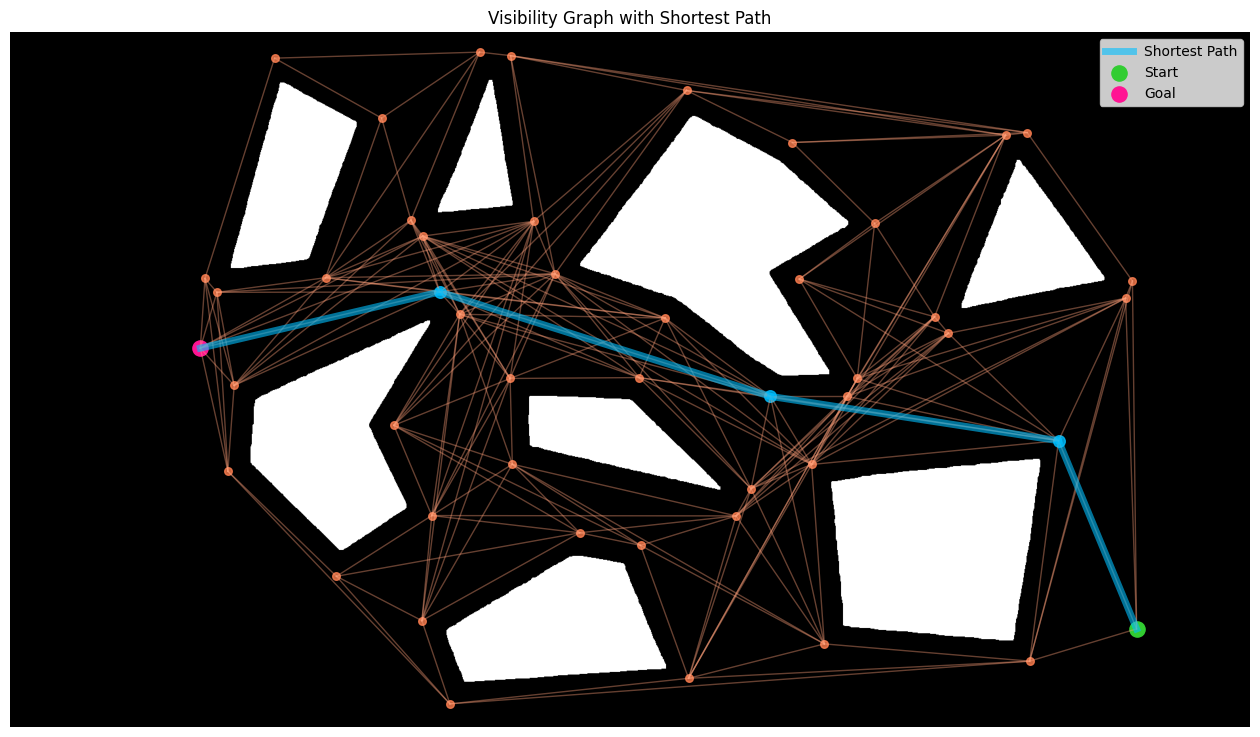

In [821]:
from shapely.geometry import Polygon
start_node = tuple(robot_pos_px / pxl_per_cm_x)
goal_node = tuple(target_pos_px / pxl_per_cm_x)

polygon_nodes = [tuple(pt) for pts in final_polygons for pt in pts]
polygons = [Polygon(pts) for pts in final_polygons]
vis_graph, indexed_points = construct_visibility_graph(polygon_nodes, polygons, start_node, goal_node)

# Visualize the visibility graph
plt.figure(figsize=(16, 10))
plt.imshow(obstacle_mask, cmap="gray", alpha=1)

# Plot all edges
for u, v in vis_graph.edges():
    p1 = vis_graph.nodes[u]['pos']
    p2 = vis_graph.nodes[v]['pos']
    xs = [p1[0] * pxl_per_cm_x, p2[0] * pxl_per_cm_x]
    ys = [p1[1] * pxl_per_cm_x, p2[1] * pxl_per_cm_x]
    plt.plot(xs, ys, color="lightsalmon", alpha=0.5, linewidth=1)

# Plot all nodes
for i in vis_graph.nodes():
    pt = vis_graph.nodes[i]['pos']
    plt.scatter(pt[0] * pxl_per_cm_x, pt[1] * pxl_per_cm_x, color="coral", s=30, alpha=0.8, marker="o")

# Highlight start and goal nodes
plt.scatter(start_node[0] * pxl_per_cm_x, start_node[1] * pxl_per_cm_x, color="limegreen", s=80, marker="o", label="Start")
plt.scatter(goal_node[0] * pxl_per_cm_x, goal_node[1] * pxl_per_cm_x, color="deeppink", s=80, marker="o", label="Goal")


plt.title(f"Visibility Graph ({vis_graph.number_of_nodes()} Nodes, {vis_graph.number_of_edges()} Edges)")
plt.legend()
plt.axis("off")
plt.show()

# Now with a shortest path overlay bc why not
plt.figure(figsize=(16, 10))
plt.imshow(obstacle_mask, cmap="gray", alpha=1)

# Plot all edges
for u, v in vis_graph.edges():
    p1 = vis_graph.nodes[u]['pos']
    p2 = vis_graph.nodes[v]['pos']
    xs = [p1[0] * pxl_per_cm_x, p2[0] * pxl_per_cm_x]
    ys = [p1[1] * pxl_per_cm_x, p2[1] * pxl_per_cm_x]
    plt.plot(xs, ys, color="lightsalmon", alpha=0.4, linewidth=1)

# Cheeky A* shortest path with networkx (start is second-last node, goal is last node)
def euclidean_distance(a, b):
    return np.linalg.norm(np.array(vis_graph.nodes[a]['pos']) - np.array(vis_graph.nodes[b]['pos']))
shortest_path = nx.astar_path(vis_graph, len(indexed_points) - 2, len(indexed_points) - 1, heuristic=euclidean_distance)
# Plot the path
for i in range(len(shortest_path) - 1):
    u = shortest_path[i]
    v = shortest_path[i + 1]
    p1 = vis_graph.nodes[u]['pos']
    p2 = vis_graph.nodes[v]['pos']
    xs = [p1[0] * pxl_per_cm_x, p2[0] * pxl_per_cm_x]
    ys = [p1[1] * pxl_per_cm_x, p2[1] * pxl_per_cm_x]
    plt.plot(xs, ys, color="deepskyblue", alpha=0.6, linewidth=5, label="Shortest Path" if i == 0 else "")

# Plot all nodes
for i in vis_graph.nodes():
    pt = vis_graph.nodes[i]['pos']
    color = "deepskyblue" if i in shortest_path else "coral"
    size = 70 if i in shortest_path else 30
    plt.scatter(pt[0] * pxl_per_cm_x, pt[1] * pxl_per_cm_x, color=color, s=size, alpha=0.8, marker="o")

# Highlight start and goal nodes
plt.scatter(start_node[0] * pxl_per_cm_x, start_node[1] * pxl_per_cm_x, color="limegreen", s=120, marker="o", label="Start")
plt.scatter(goal_node[0] * pxl_per_cm_x, goal_node[1] * pxl_per_cm_x, color="deeppink", s=120, marker="o", label="Goal")

plt.title("Visibility Graph with Shortest Path")
plt.legend()
plt.axis("off")
plt.show()